In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

import xgboost

from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# conda install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [4]:
raw_df = pd.read_csv('data/rosbank_train.csv')
# target_sum - можно выкинуть, переменная участвует в другой задаче
raw_df.drop(labels='target_sum', axis=1, inplace=True)
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [6]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [7]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [8]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  394017
Total transactions in test dataset:  96496


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. Обязательная часть(=ДЗ2): Провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи (Визуализировать, чтобы понять как это влияет на таргет. Главное - сформировать гипотезу - Если произошло событие N клиент после этого оттечет. И проверить ее на данных. Результат - работающая фича.)
5. Обязательная часть(=ДЗ4 с семинара 5): Отобрать важные фичи (увеличивают метрику на тесте) и обучить модель, попробовать подобрать гипперпараметры (Тип алгоритма - Случайный лес). Метрика оценки качества - ROC AUC.

Совет: документировать в удобно формате (я делаю в экселе):
- Параметры - Тип и гиперпараметры модели - Метрику (чтобы анализировать ход работы)

    

## Homework 2 - Exploratory analysis


In [9]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [10]:
raw_df.describe()

,cl_id,MCC,currency,amount,target_flag
count,490513.000000,490513.000000,490513.000000,4.905130e+05,490513.000000
mean,4802.127361,5699.783822,810.601854,5.723594e+03,0.652588
std,2986.492835,662.933380,38.223123,7.703763e+04,0.476148
min,0.000000,742.000000,32.000000,4.000000e-02,0.000000
25%,2193.000000,5411.000000,810.000000,2.240000e+02,0.000000
50%,4576.000000,5661.000000,810.000000,6.240000e+02,1.000000
75%,7390.000000,5941.000000,810.000000,2.176000e+03,1.000000
max,10215.000000,9405.000000,986.000000,3.583500e+07,1.000000


In [11]:
print('Тип канала')
print(raw_df.channel_type.value_counts())

Тип канала
type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
Name: channel_type, dtype: int64


In [12]:
print('Основные категории ')
print(raw_df.trx_category.value_counts(), '\n')

Основные категории 
POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64 



In [13]:
print('MCC')
print(raw_df.MCC.value_counts(), '\n')

MCC
5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
5541     19816
5912     18728
5999     13073
6012     10056
5921      8578
5331      7641
4121      6266
5211      6262
4829      6205
5691      5161
5261      4803
4111      4362
5977      4300
5200      3460
5732      3271
5311      3258
5533      2946
5651      2915
4812      2857
5641      2710
8099      2674
5722      2667
5661      2601
8999      2599
5941      2597
         ...  
3064         1
3678         1
8675         1
3548         1
3607         1
3730         1
3029         1
3535         1
3722         1
7333         1
7339         1
3387         1
3715         1
3508         1
3640         1
3513         1
3515         1
3191         1
5937         1
3634         1
3520         1
7217         1
3659         1
3628         1
3778         1
5960         1
3625         1
7211         1
7631         1
3703         1
Name: MCC, Length: 344, dtype: int64 



In [45]:
# Так как MCC значений очень много, возьмем, например, top 100 значениями 
list(raw_df.MCC.value_counts().nlargest(n=100).index)

[5411,
 6011,
 5814,
 5812,
 5499,
 5541,
 5912,
 5999,
 6012,
 5921,
 5331,
 4121,
 5211,
 4829,
 5691,
 5261,
 4111,
 5977,
 5200,
 5732,
 5311,
 5533,
 5651,
 4812,
 5641,
 8099,
 5722,
 5661,
 8999,
 5941,
 5945,
 7011,
 4814,
 5712,
 7832,
 7230,
 4112,
 5813,
 5964,
 5699,
 5992,
 4511,
 5995,
 5983,
 4900,
 7997,
 5942,
 5621,
 5399,
 5735,
 7311,
 5300,
 4784,
 4816,
 5944,
 7523,
 5719,
 4722,
 5943,
 7298,
 5947,
 9399,
 7922,
 7542,
 8021,
 6051,
 3011,
 7538,
 4789,
 5655,
 5309,
 6300,
 5542,
 5511,
 7999,
 8043,
 5816,
 5611,
 8011,
 7299,
 7399,
 5631,
 5251,
 5462,
 5441,
 7995,
 7991,
 4215,
 5948,
 5714,
 5811,
 7941,
 5993,
 5994,
 5949,
 5422,
 9222,
 7996,
 7512,
 7994]

In [46]:
print('currency')
print(raw_df.currency.value_counts())
print(len(raw_df.currency.unique()))
# take top 20 
list(raw_df.currency.value_counts().nlargest(n=20).index);

currency
810    477644
978      5536
840      1921
933       561
985       423
764       412
203       399
949       390
975       297
826       267
784       262
980       209
392       197
981       164
348       151
756       126
578       110
410       110
752       109
702       100
398        99
191        95
360        72
156        70
51         60
376        60
352        59
484        53
704        52
124        41
356        40
144        40
417        35
498        35
344        34
643        32
480        32
214        31
944        31
554        27
458        20
36         17
32         12
986        12
208        12
504        11
690         8
941         8
901         5
946         4
604         3
170         3
462         2
44          2
608         2
634         2
710         2
188         1
788         1
Name: currency, dtype: int64
59


In [47]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['hour_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'hour_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df

# transaction_by_day_count(raw_df)

### Пример агрегирования с помощью SQL

In [48]:
# в терминале выполнить команду touch transactions.db
# или просто создать файл с названием transactions.db
import sqlite3
conn = sqlite3.connect('transactions.db')

In [42]:
raw_df.to_sql('transactions_raw', if_exists='replace', con=conn)

In [43]:
check = pd.io.sql.read_sql("""
    select * from transactions_raw limit 100
    """, conn
)

In [44]:
pd.io.sql.read_sql("""
    select count(*), count(distinct cl_id) from transactions_raw
    """, conn
)

,count(*),count(distinct cl_id)
0,490513,5000


In [45]:
MCC_list = raw_df.MCC.value_counts().head(20).index.tolist()
for MCC_code in MCC_list:
    print(
        'sum(case when MCC = {0} then amount else 0 end) as MCC_{0},'.format(MCC_code)
    )

sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
sum(case when MCC = 5499 then amount else 0 end) as MCC_5499,
sum(case when MCC = 5541 then amount else 0 end) as MCC_5541,
sum(case when MCC = 5912 then amount else 0 end) as MCC_5912,
sum(case when MCC = 5999 then amount else 0 end) as MCC_5999,
sum(case when MCC = 6012 then amount else 0 end) as MCC_6012,
sum(case when MCC = 5921 then amount else 0 end) as MCC_5921,
sum(case when MCC = 5331 then amount else 0 end) as MCC_5331,
sum(case when MCC = 4121 then amount else 0 end) as MCC_4121,
sum(case when MCC = 5211 then amount else 0 end) as MCC_5211,
sum(case when MCC = 4829 then amount else 0 end) as MCC_4829,
sum(case when MCC = 5691 then amount else 0 end) as MCC_5691,
sum(case when MCC = 5261 then amount else 0 end) as MCC_5261,
sum(case

In [46]:
datamart_check = pd.io.sql.read_sql("""
    select
        cl_id,
        target_flag,
        sum(case when MCC = 5411 then amount else 0 end) as MCC_5411,
        sum(case when MCC = 6011 then amount else 0 end) as MCC_6011,
        sum(case when MCC = 5814 then amount else 0 end) as MCC_5814,
        sum(case when MCC = 5812 then amount else 0 end) as MCC_5812,
        sum(case when MCC = 5499 then amount else 0 end) as MCC_5499,

/*------------------average amount---------------------------------*/
        avg(case when MCC = 5411 then amount else 0 end) as MCC_5411_avg,
        avg(case when MCC = 6011 then amount else 0 end) as MCC_6011_avg,
        avg(case when MCC = 5814 then amount else 0 end) as MCC_5814_avg,
        avg(case when MCC = 5812 then amount else 0 end) as MCC_5812_avg,
        avg(case when MCC = 5499 then amount else 0 end) as MCC_5499_avg
    from transactions_raw
    group by 1, 2
    order by 1
    """, conn)

In [47]:
datamart_check

,cl_id,target_flag,MCC_5411,MCC_6011,MCC_5814,MCC_5812,MCC_5499,MCC_5411_avg,MCC_6011_avg,MCC_5814_avg,MCC_5812_avg,MCC_5499_avg
0,0,0,2031.00,20000.0,0.00,0.00,0.00,406.200000,4000.000000,0.000000,0.000000,0.000000
1,1,0,14629.46,145000.0,82441.17,3180.01,492.80,140.667885,1394.230769,792.703558,30.577019,4.738462
2,5,1,44925.40,208000.0,247.00,3309.00,7196.70,316.376056,1464.788732,1.739437,23.302817,50.680986
3,9,0,39.00,540000.0,0.00,0.00,0.00,1.000000,13846.153846,0.000000,0.000000,0.000000
4,10,0,53920.36,854000.0,2010.00,319.00,13225.02,116.458661,1844.492441,4.341253,0.688985,28.563758
5,11,0,31084.62,182000.0,5653.00,11814.80,383.60,143.247097,838.709677,26.050691,54.446083,1.767742
6,14,1,20408.96,37000.0,23894.06,5659.00,827.00,150.065882,272.058824,175.691618,41.610294,6.080882
7,20,0,9834.43,215000.0,0.00,3023.33,1247.73,127.719870,2792.207792,0.000000,39.264026,16.204286
8,21,0,25978.04,65000.0,4853.00,7540.00,1277.45,209.500323,524.193548,39.137097,60.806452,10.302016
9,22,0,241.82,139000.0,0.00,0.00,2610.00,4.098644,2355.932203,0.000000,0.000000,44.237288


### Агрегирование с помощью Pandas и обучение базовой модели

In [49]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

###  Service functions

In [50]:
# makes index 
def make_index(df, label):
    df.index = df[label]
    df = df.drop(label, axis=1)
    return df

In [51]:
# top 100 MCC categories
top_mcc_cat_list = list(raw_df.MCC.value_counts().nlargest(n=100).index)
print(top_mcc_cat_list)

[5411, 6011, 5814, 5812, 5499, 5541, 5912, 5999, 6012, 5921, 5331, 4121, 5211, 4829, 5691, 5261, 4111, 5977, 5200, 5732, 5311, 5533, 5651, 4812, 5641, 8099, 5722, 5661, 8999, 5941, 5945, 7011, 4814, 5712, 7832, 7230, 4112, 5813, 5964, 5699, 5992, 4511, 5995, 5983, 4900, 7997, 5942, 5621, 5399, 5735, 7311, 5300, 4784, 4816, 5944, 7523, 5719, 4722, 5943, 7298, 5947, 9399, 7922, 7542, 8021, 6051, 3011, 7538, 4789, 5655, 5309, 6300, 5542, 5511, 7999, 8043, 5816, 5611, 8011, 7299, 7399, 5631, 5251, 5462, 5441, 7995, 7991, 4215, 5948, 5714, 5811, 7941, 5993, 5994, 5949, 5422, 9222, 7996, 7512, 7994]


In [52]:
# top 20 currency categories
top_currency_list = list(raw_df.currency.value_counts().nlargest(n=20).index)
print(top_currency_list)

[810, 978, 840, 933, 985, 764, 203, 949, 975, 826, 784, 980, 392, 981, 348, 756, 578, 410, 752, 702]


In [53]:
# prepare target
def prepare_target_df(df):
    df_targets = df[['cl_id', 'target_flag']].drop_duplicates().copy()
    df_targets.index = df_targets['cl_id']
    df_targets = df_targets.drop('cl_id', axis=1)
    return df_targets

In [54]:
# make pipeline 
def df_pipeline_creation(df, df_target, mcc_limit=100, currency_limit=20):
    top_mcc_cat_list = list(raw_df.MCC.value_counts().nlargest(n=mcc_limit).index)
    top_currency_list = list(raw_df.currency.value_counts().nlargest(n=currency_limit).index)
    
    # day
    new_day_count_df = transaction_by_day_count(df)
    new_day_count_df = make_index(df=new_day_count_df, label='cl_id')
    # hour
    new_hour_count_df = transaction_by_hour_count(df)
    new_hour_count_df = make_index(df=new_hour_count_df, label='cl_id')
    # time df
    df_time = pd.merge(new_day_count_df, new_hour_count_df,left_index=True,right_index=True)

    # mcc
    df_mcc_mean = get_aggregated_df(df[df['MCC'].isin(top_mcc_cat_list)], 
                                    agg_type='mean', col_to_groupby='MCC')
    df_mcc_sum = get_aggregated_df(df[df['MCC'].isin(top_mcc_cat_list)],
                                   agg_type='sum', col_to_groupby='MCC')
    df_mcc = pd.merge(df_mcc_mean, df_mcc_sum, left_index=True, right_index=True)

    # trx_category
    df_trx_mean = get_aggregated_df(df, agg_type='mean', col_to_groupby='trx_category')
    df_trx_sum = get_aggregated_df(df, agg_type='sum', col_to_groupby='trx_category')
    df_trx_category = pd.merge(df_trx_mean, df_trx_sum, left_index=True,right_index=True)

    # merge mcc and trx_category 
    df_trx_mcc = pd.merge(df_mcc, df_trx_category, left_index=True, right_index=True)
    
    # merge with currency
    df_currency = get_aggregated_df(df[df['currency'].isin(top_currency_list)], 
                                    agg_type='sum', col_to_groupby='currency')
    
    # feature df
    df_feature1 = pd.merge(df_time, df_trx_mcc, left_index=True, right_index=True)
    df_feature2 = pd.merge(df_feature1, df_currency, left_index=True, right_index=True)
    
    # final df
    df_final = pd.merge(df_feature2, df_target, left_index=True, right_index=True)
    
    return df_final

### Prepare the Data

In [55]:
#%%time
#get targets
df_targets = prepare_target_df(df=raw_df)

df_train = df_pipeline_creation(df=transactions_train, df_target=df_targets, 
                                mcc_limit=50, currency_limit=3)
#df_train.head()

df_test = df_pipeline_creation(df=transactions_test, df_target=df_targets,
                               mcc_limit=50, currency_limit=3)
#df_test.head()

In [119]:
print(df_train.columns)
print(df_test.columns)

Index(['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'hour_00', 'hour_01', 'hour_02',
       ...
       'trx_category_sum_CAT', 'trx_category_sum_DEPOSIT',
       'trx_category_sum_POS', 'trx_category_sum_WD_ATM_OTHER',
       'trx_category_sum_WD_ATM_PARTNER', 'trx_category_sum_WD_ATM_ROS',
       'currency_sum_810', 'currency_sum_840', 'currency_sum_978',
       'target_flag'],
      dtype='object', length=155)
Index(['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'hour_00', 'hour_01', 'hour_02',
       ...
       'trx_category_sum_CAT', 'trx_category_sum_DEPOSIT',
       'trx_category_sum_POS', 'trx_category_sum_WD_ATM_OTHER',
       'trx_category_sum_WD_ATM_PARTNER', 'trx_category_sum_WD_ATM_ROS',
       'currency_sum_810', 'currency_sum_840', 'currency_sum_978',
       'target_flag'],
      dtype='object', length=155)


### Make train/test split

In [56]:
X_test = df_test.drop(['target_flag'], axis=1)
y_test = df_test['target_flag']
X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

### Use Random Forest to get the information about feature importance

In [58]:
cols = list(filter(lambda x: x in X_test.columns, X_train.columns))
print(len(cols))

154


In [59]:
clf = RandomForestClassifier(n_estimators=75, max_depth=10, random_state=42).fit(X_train[cols], y_train)

In [60]:
y_train_predict = clf.predict_proba(X_train[cols])[:, 1]
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)

print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.97
Test:  0.81


In [61]:
features = X_train.columns
importances = clf.feature_importances_
for feature in sorted(zip(features, clf.feature_importances_), key = lambda t: -t[1]):
    print(feature)

('trx_category_mean_WD_ATM_OTHER', 0.04360622580220672)
('MCC_mean_5411', 0.03242517524224878)
('trx_category_sum_POS', 0.03208828604406117)
('trx_category_sum_WD_ATM_OTHER', 0.030076423009464986)
('trx_category_sum_DEPOSIT', 0.029667057042153305)
('trx_category_mean_DEPOSIT', 0.028824601077208467)
('MCC_sum_5411', 0.02353685421095806)
('MCC_mean_5814', 0.02262014803913445)
('MCC_sum_5814', 0.02083231587192607)
('day_4', 0.020302792988516862)
('trx_category_sum_WD_ATM_ROS', 0.01942669912669222)
('hour_00', 0.01879127189092349)
('day_2', 0.01793156344493169)
('MCC_mean_5812', 0.01786541511539396)
('day_6', 0.017862815891409436)
('day_1', 0.017774735558330257)
('day_0', 0.01707233301268588)
('currency_sum_810', 0.016515107458378607)
('MCC_sum_5999', 0.016097553917764112)
('day_5', 0.014432671977223484)
('MCC_sum_6011', 0.014146715012346288)
('day_3', 0.013662853317408873)
('MCC_sum_5812', 0.013345554955230682)
('MCC_sum_5691', 0.013154896729166369)
('MCC_mean_5999', 0.012937857936285685)

## Homework 4 - Backward feature selection and Trying out different algorithms

#### Backward selection application

In [64]:
cols

['day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'hour_00',
 'hour_01',
 'hour_02',
 'hour_03',
 'hour_04',
 'hour_05',
 'hour_06',
 'hour_07',
 'hour_08',
 'hour_09',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'MCC_mean_4111',
 'MCC_mean_4112',
 'MCC_mean_4121',
 'MCC_mean_4511',
 'MCC_mean_4812',
 'MCC_mean_4814',
 'MCC_mean_4829',
 'MCC_mean_4900',
 'MCC_mean_5200',
 'MCC_mean_5211',
 'MCC_mean_5261',
 'MCC_mean_5311',
 'MCC_mean_5331',
 'MCC_mean_5399',
 'MCC_mean_5411',
 'MCC_mean_5499',
 'MCC_mean_5533',
 'MCC_mean_5541',
 'MCC_mean_5621',
 'MCC_mean_5641',
 'MCC_mean_5651',
 'MCC_mean_5661',
 'MCC_mean_5691',
 'MCC_mean_5699',
 'MCC_mean_5712',
 'MCC_mean_5722',
 'MCC_mean_5732',
 'MCC_mean_5735',
 'MCC_mean_5812',
 'MCC_mean_5813',
 'MCC_mean_5814',
 'MCC_mean_5912',
 'MCC_mean_5921',
 'MCC_mean_5941',
 'MCC_mean_5942',
 'MCC_mean_5

In [66]:
def get_formula(_cols):
    return 'target_flag ~ ' + " + ".join(_cols)

In [73]:
lm = smf.ols(get_formula(cols), df_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)
lm_res = lm.summary()
lm_res.tables[1]

RMSE: 0.45709404028851947
R^2: 0.1551340500283852


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3845,0.017,22.643,0.000,0.351,0.418
day_0,0.0027,0.002,1.775,0.076,-0.000,0.006
day_1,0.0021,0.002,1.211,0.226,-0.001,0.005
day_2,0.0026,0.002,1.540,0.124,-0.001,0.006
day_3,0.0042,0.002,2.461,0.014,0.001,0.008
day_4,0.0032,0.002,1.900,0.058,-0.000,0.006
day_5,0.0050,0.002,3.184,0.001,0.002,0.008
day_6,0.0029,0.001,2.012,0.044,7.43e-05,0.006
hour_00,-0.0022,0.001,-2.188,0.029,-0.004,-0.000
hour_01,0.0259,0.020,1.292,0.196,-0.013,0.065


In [102]:
# выберем все параметры, p_value которых < 0.005, что нам может говорить о возможном влиянии на целевую переменную
cols = ['day_5', 'MCC_mean_4829', 'MCC_mean_4900', 'MCC_mean_5661', 'MCC_mean_6011', 'MCC_sum_4812', 'MCC_sum_4900', 
       'MCC_sum_5200', 'MCC_sum_8999', 'trx_category_mean_POS', 'currency_sum_810']

In [103]:
lm = smf.ols(get_formula(cols), df_train).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)
lm_res = lm.summary()
lm_res.tables[1]

RMSE: 0.47635892873015656
R^2: 0.0824171042624453


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4169,0.014,29.247,0.000,0.389,0.445
day_5,0.0071,0.001,11.831,0.000,0.006,0.008
MCC_mean_4829,1.375e-06,4.59e-07,2.994,0.003,4.75e-07,2.28e-06
MCC_mean_4900,-5.568e-06,1.54e-06,-3.622,0.000,-8.58e-06,-2.55e-06
MCC_mean_5661,1.379e-05,2.32e-06,5.936,0.000,9.24e-06,1.83e-05
MCC_mean_6011,-8.173e-07,3.01e-07,-2.711,0.007,-1.41e-06,-2.26e-07
MCC_sum_4812,-1.847e-06,3.9e-07,-4.741,0.000,-2.61e-06,-1.08e-06
MCC_sum_4900,5.796e-06,1.51e-06,3.843,0.000,2.84e-06,8.75e-06
MCC_sum_5200,-1.409e-06,5.86e-07,-2.405,0.016,-2.56e-06,-2.6e-07
MCC_sum_8999,-1.759e-06,6.59e-07,-2.668,0.008,-3.05e-06,-4.66e-07


#### Проверка качества с использованием выбранных переменных

In [104]:
clf = RandomForestClassifier(n_estimators=75, max_depth=10, random_state=42).fit(X_train[cols], y_train)

y_train_predict = clf.predict_proba(X_train[cols])[:, 1]
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)

print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.89
Test:  0.71


#### Forward selection

In [94]:
skf = StratifiedKFold(n_splits=4)

# custom_feature_names=feature_names
sfs_forward = SFS(clf, 
           k_features=12, 
           forward=True, 
           floating=True, 
           verbose=1,
           scoring='roc_auc',
           cv=skf,
           n_jobs=-1)

sfs_forward = sfs_forward.fit(X_train.values, y_train.values,custom_feature_names=X_train.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 out of 154 | elapsed:   24.5s finished
Features: 1/12[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 153 out of 153 | elapsed:   25.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
Features: 2/12[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 152 out of 152 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   

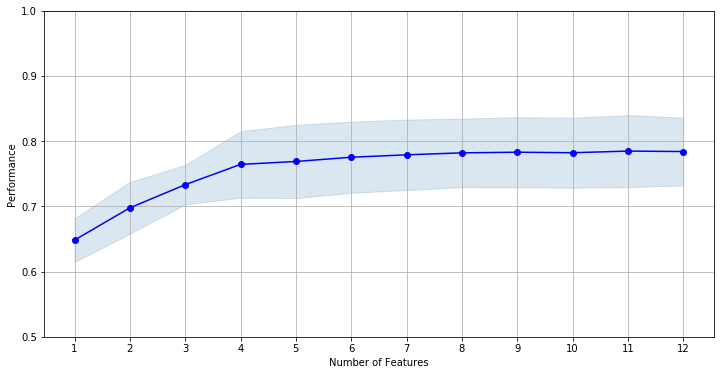

In [96]:
fig1 = plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.grid()
fig1.set_size_inches(12, 6)
plt.show()

In [98]:
sfs_forward.get_metric_dict()

{1: {'feature_idx': (3,),
  'cv_scores': array([0.67979283, 0.66927125, 0.59293861, 0.65090521]),
  'avg_score': 0.6482269720619676,
  'feature_names': ('day_3',),
  'ci_bound': 0.05378498644771101,
  'std_dev': 0.03355309602103666,
  'std_err': 0.019371889019890877},
 2: {'feature_idx': (3, 138),
  'cv_scores': array([0.71676295, 0.7536186 , 0.66256593, 0.65787444]),
  'avg_score': 0.6977054771435212,
  'feature_names': ('day_3', 'trx_category_mean_WD_ATM_OTHER'),
  'ci_bound': 0.06367067350326355,
  'std_dev': 0.03972015915363302,
  'std_err': 0.022932444579604805},
 3: {'feature_idx': (3, 138, 147),
  'cv_scores': array([0.73274444, 0.78119506, 0.71997832, 0.69891229]),
  'avg_score': 0.7332075277129847,
  'feature_names': ('day_3',
   'trx_category_mean_WD_ATM_OTHER',
   'trx_category_sum_POS'),
  'ci_bound': 0.04845004901633424,
  'std_dev': 0.03022496154106924,
  'std_err': 0.01745038968198241},
 4: {'feature_idx': (3, 136, 138, 147),
  'cv_scores': array([0.76507405, 0.83611453,

In [105]:
# набор из 12 перемнных, наилучшим образом объясняющих целевую переменную
cols = ['day_3',
   'day_5',
   'hour_15',
   'MCC_mean_4829',
   'MCC_mean_5499',
   'MCC_mean_5812',
   'MCC_mean_5912',
   'MCC_mean_5941',
   'trx_category_mean_DEPOSIT',
   'trx_category_mean_WD_ATM_OTHER',
   'trx_category_sum_POS',
   'trx_category_sum_WD_ATM_ROS']

#### Проверка качества модели с использованием выбранных переменных

In [114]:
clf = RandomForestClassifier(n_estimators=75, max_depth=10).fit(X_train[cols], y_train)

y_train_predict = clf.predict_proba(X_train[cols])[:, 1]
y_test_predict = clf.predict_proba(X_test[cols])[:, 1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)

print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.95
Test:  0.8


Стратегия forward selection получилась эффективнее, чем backward selection, судя по финальному качеству

### XGboost

In [113]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
xgb.fit(X_train[cols], y_train)
y_train_predict = xgb.predict_proba(X_train[cols])[:, 1]
y_test_predict = xgb.predict_proba(X_test[cols])[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.92
Test:  0.79


### Grid Search using Random Forest

In [115]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 6, 10],
    'max_features': [3, 7, 10],
    'n_estimators': [10, 40, 70, 100]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 7, n_jobs = -1, verbose = 2)

In [116]:
grid_search.fit(X_train[cols], y_train)
grid_search.best_params_

Fitting 7 folds for each of 36 candidates, totalling 252 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 252 out of 252 | elapsed:   28.8s finished


{'bootstrap': True, 'max_depth': 10, 'max_features': 7, 'n_estimators': 100}

In [117]:
y_train_predict = grid_search.predict_proba(X_train[cols])[:, 1]
y_test_predict = grid_search.predict_proba(X_test[cols])[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.95
Test:  0.8
